# Cyclistic Case Study

In [2]:
# Load packages
import pandas as pd
import numpy as np
import glob
import datetime as dt
from haversine import haversine, Unit
import seaborn as sns
import matplotlib.pyplot as plt

In [3]:
# Get a list of all CSV files in the directory
csv_files = glob.glob("*.csv")

# Create an empty dataframe to store the combined data
combined_df = pd.DataFrame()

# Loop through each CSV file
for csv_file in csv_files:
    # Read the CSV file into a dataframe
    df = pd.read_csv(csv_file)

    # Append the dataframe to the combined dataframe
    combined_df = pd.concat([combined_df, df], ignore_index=True)

# Print the combined dataframe
print(combined_df)

                  ride_id  rideable_type           started_at  \
0        4449097279F8BBE7   classic_bike  2023-10-08 10:36:26   
1        9CF060543CA7B439  electric_bike  2023-10-11 17:23:59   
2        667F21F4D6BDE69C  electric_bike  2023-10-12 07:02:33   
3        F92714CC6B019B96   classic_bike  2023-10-24 19:13:03   
4        5E34BA5DE945A9CC   classic_bike  2023-10-09 18:19:26   
...                   ...            ...                  ...   
5854539  30B44BD4C16E688C   classic_bike  2023-11-24 08:39:27   
5854540  094A79892812BAB9   classic_bike  2023-11-06 09:07:20   
5854541  F0A7DF8A44FDA3CB  electric_bike  2023-11-10 19:35:30   
5854542  4D5E3685BB913A3C   classic_bike  2023-11-27 09:11:23   
5854543  1FA95C375BE4B6A6  electric_bike  2023-11-20 16:16:03   

                    ended_at                    start_station_name  \
0        2023-10-08 10:49:19  Orleans St & Chestnut St (NEXT Apts)   
1        2023-10-11 17:36:08             Desplaines St & Kinzie St   
2        

In [4]:
combined_df.head()

,ride_id,rideable_type,started_at,ended_at,start_station_name,start_station_id,end_station_name,end_station_id,start_lat,start_lng,end_lat,end_lng,member_casual
0,4449097279F8BBE7,classic_bike,2023-10-08 10:36:26,2023-10-08 10:49:19,Orleans St & Chestnut St (NEXT Apts),620,Sheffield Ave & Webster Ave,TA1309000033,41.898203,-87.637536,41.921540,-87.653818,member
1,9CF060543CA7B439,electric_bike,2023-10-11 17:23:59,2023-10-11 17:36:08,Desplaines St & Kinzie St,TA1306000003,Sheffield Ave & Webster Ave,TA1309000033,41.888641,-87.644415,41.921540,-87.653818,member
2,667F21F4D6BDE69C,electric_bike,2023-10-12 07:02:33,2023-10-12 07:06:53,Orleans St & Chestnut St (NEXT Apts),620,Franklin St & Lake St,TA1307000111,41.898073,-87.637514,41.885837,-87.635500,member
3,F92714CC6B019B96,classic_bike,2023-10-24 19:13:03,2023-10-24 19:18:29,Desplaines St & Kinzie St,TA1306000003,Franklin St & Lake St,TA1307000111,41.888716,-87.644448,41.885837,-87.635500,member
4,5E34BA5DE945A9CC,classic_bike,2023-10-09 18:19:26,2023-10-09 18:30:56,Desplaines St & Kinzie St,TA1306000003,Franklin St & Lake St,TA1307000111,41.888716,-87.644448,41.885837,-87.635500,member


In [5]:
combined_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5854544 entries, 0 to 5854543
Data columns (total 13 columns):
 #   Column              Dtype  
---  ------              -----  
 0   ride_id             object 
 1   rideable_type       object 
 2   started_at          object 
 3   ended_at            object 
 4   start_station_name  object 
 5   start_station_id    object 
 6   end_station_name    object 
 7   end_station_id      object 
 8   start_lat           float64
 9   start_lng           float64
 10  end_lat             float64
 11  end_lng             float64
 12  member_casual       object 
dtypes: float64(4), object(9)
memory usage: 580.7+ MB


## Data clean
1. Remove duplicates
2. Data type: datetime
3. Missing value
4. Error: negative duration / distance
5. Outliers: extremely small or large

In [7]:
# ride_id is the primary key. 
# Each row represents a single ride
# Remove any duplicative rides
rides = combined_df.drop_duplicates()

In [8]:
# convert to datetime
# using mixed format: '%Y-%m-%d %H:%M:%S.%f' '%Y-%m-%d %H:%M:%S'
rides['started_at'] = pd.to_datetime(rides['started_at'],format='mixed') 
rides['ended_at'] = pd.to_datetime(rides['ended_at'],format='mixed') 

In [9]:
# Check columns with missing value
col_with_na = rides.isna().any()
col_with_na 
# Both start and end station have missing value 
# However the start lat and lng don't. It can provide information of the start point.
# We can focus on clean the end lat and lng.

ride_id               False
rideable_type         False
started_at            False
ended_at              False
start_station_name     True
start_station_id       True
end_station_name       True
end_station_id         True
start_lat             False
start_lng             False
end_lat                True
end_lng                True
member_casual         False
dtype: bool

In [10]:
end_lat_lng = rides[['end_lat','end_lng']]
end_lat_lng[end_lat_lng.isna().any(axis=1)] 
# 7441 records. 0.1 percent of the whole dataset
# It is ok to remove the missing data. 7441/5854544 

,end_lat,end_lng
30731,NaN,NaN
30922,NaN,NaN
30928,NaN,NaN
30932,NaN,NaN
30993,NaN,NaN
...,...,...
5848650,NaN,NaN
5848651,NaN,NaN
5848687,NaN,NaN
5848703,NaN,NaN


In [11]:
# Remove na
rides = rides.dropna(subset=['end_lat','end_lng'])

In [12]:
# Calculate duration
rides['duration_m'] = round((rides['ended_at']-rides['started_at']).dt.total_seconds()/60,2)

In [13]:
# check how many durations are below 0 
sum(rides['duration_m']<=0)

1089

In [14]:
# duration should be postive
rides = rides[rides['duration_m'] > 0]

In [15]:
# get month of the date
rides['month'] = rides['started_at'].dt.month 

In [16]:
# get weekday of the date
rides['weekday'] = rides['started_at'].dt.day_name()
rides.head()

,ride_id,rideable_type,started_at,ended_at,start_station_name,start_station_id,end_station_name,end_station_id,start_lat,start_lng,end_lat,end_lng,member_casual,duration_m,month,weekday
0,4449097279F8BBE7,classic_bike,2023-10-08 10:36:26,2023-10-08 10:49:19,Orleans St & Chestnut St (NEXT Apts),620,Sheffield Ave & Webster Ave,TA1309000033,41.898203,-87.637536,41.921540,-87.653818,member,12.88,10,Sunday
1,9CF060543CA7B439,electric_bike,2023-10-11 17:23:59,2023-10-11 17:36:08,Desplaines St & Kinzie St,TA1306000003,Sheffield Ave & Webster Ave,TA1309000033,41.888641,-87.644415,41.921540,-87.653818,member,12.15,10,Wednesday
2,667F21F4D6BDE69C,electric_bike,2023-10-12 07:02:33,2023-10-12 07:06:53,Orleans St & Chestnut St (NEXT Apts),620,Franklin St & Lake St,TA1307000111,41.898073,-87.637514,41.885837,-87.635500,member,4.33,10,Thursday
3,F92714CC6B019B96,classic_bike,2023-10-24 19:13:03,2023-10-24 19:18:29,Desplaines St & Kinzie St,TA1306000003,Franklin St & Lake St,TA1307000111,41.888716,-87.644448,41.885837,-87.635500,member,5.43,10,Tuesday
4,5E34BA5DE945A9CC,classic_bike,2023-10-09 18:19:26,2023-10-09 18:30:56,Desplaines St & Kinzie St,TA1306000003,Franklin St & Lake St,TA1307000111,41.888716,-87.644448,41.885837,-87.635500,member,11.50,10,Monday


In [17]:
# distance isn't the key to identify how far they ride the bike.
# because distance can be 0. Users can return the bike to the original station.
# It helps identfiy outliers.

In [18]:
def calculate_distance(rides):
    coords_1 = (rides['start_lat'],rides['start_lng'])
    coords_2 = (rides['end_lat'],rides['end_lng'])
    return haversine(coords_1, coords_2, unit=Unit.MILES)

In [19]:
rides['distance'] = rides.apply(calculate_distance, axis=1)

In [20]:
# Outliers
# dataset shape 
rides.shape

(5846014, 17)

In [21]:
# max of duration is over 24 hours. 
# the potential reasons: 1. system error 2. user forgot to return the bike 3. user couldn't find a place to return.
rides['duration_m'].agg(['min','mean','max'])

min        0.010000
mean      15.439345
max     1509.370000
Name: duration_m, dtype: float64

In [22]:
rides['duration_m'].describe()

count    5.846014e+06
mean     1.543935e+01
std      3.315466e+01
min      1.000000e-02
25%      5.520000e+00
50%      9.670000e+00
75%      1.713000e+01
max      1.509370e+03
Name: duration_m, dtype: float64

In [23]:
# calculate IQR to identify outliers
du_q1 = rides['duration_m'].describe().iloc[4]
du_q3 = rides['duration_m'].describe().iloc[6]

In [24]:
iqr_du = du_q3 - du_q1
upper_du = du_q3+1.5*iqr_du
lower_du = du_q1-1.5*iqr_du
print(upper_du)
print(lower_du)

34.545
-11.895


In [25]:
# check under each criteria, how much data will be identified as outliers
# 120min: 35370/5846014 0.6%
# 60min: 144319/5846014 2%
# upper_du: 435825/5846014 7%

In [26]:
rd_iqr = rides[rides['duration_m'] <= upper_du]

<Axes: xlabel='duration_m', ylabel='Count'>

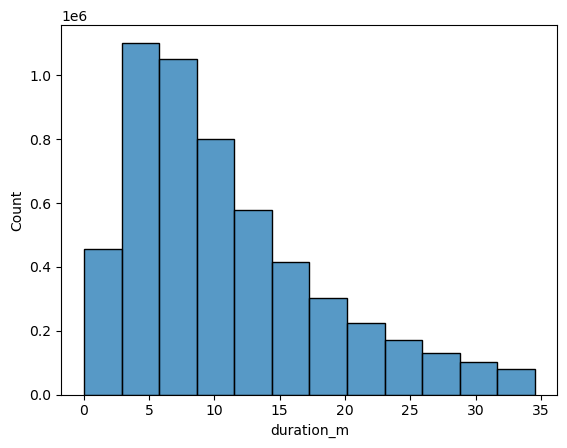

In [27]:
sns.histplot(data=rd_iqr, x="duration_m",binwidth=3)

In [28]:
rd_60 = rides[rides['duration_m'] <= 60]

<Axes: xlabel='duration_m', ylabel='Count'>

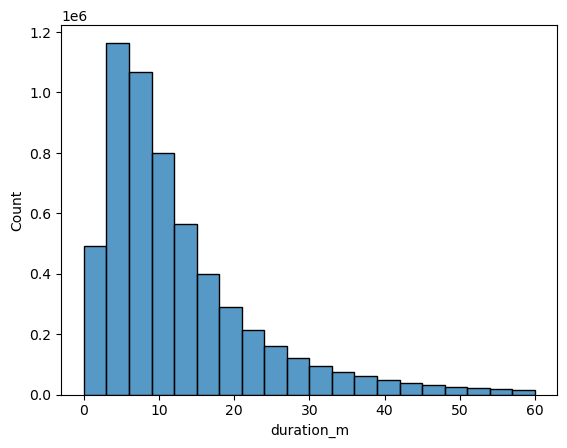

In [29]:
sns.histplot(data=rd_60, x="duration_m",binwidth=3)

In [30]:
rd_120 = rides[rides['duration_m'] <= 120]

<Axes: xlabel='duration_m', ylabel='Count'>

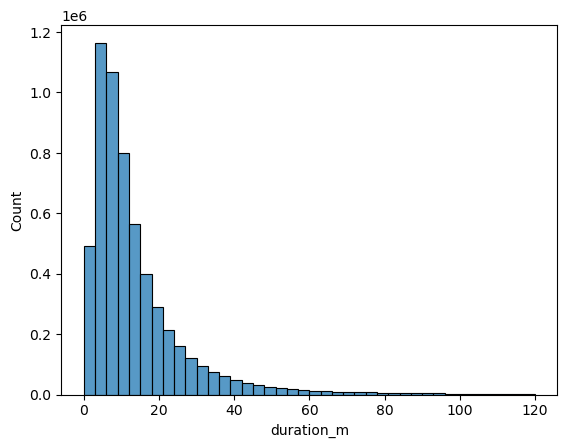

In [31]:
sns.histplot(data=rd_120, x="duration_m",binwidth=3)

In [32]:
# max of distance is over 3000 miles, which is not reasonable
rides['distance'].agg(['min','mean','max'])

min        0.000000
mean       1.326487
max     3465.144715
Name: distance, dtype: float64

In [33]:
rides['distance'].describe()

count    5.846014e+06
mean     1.326487e+00
std      2.800892e+00
min      0.000000e+00
25%      5.400602e-01
50%      9.674762e-01
75%      1.722631e+00
max      3.465145e+03
Name: distance, dtype: float64

In [34]:
# IQR
di_q1 = rides['distance'].describe().iloc[4]
di_q3 = rides['distance'].describe().iloc[6]

In [35]:
iqr_di = di_q3 - di_q1
upper_di = di_q3+1.5*iqr_di
lower_di = di_q1-1.5*iqr_di
print(upper_di)
print(lower_di)

3.4964860162071054
-1.2337952579129383


In [36]:
# check minutes per mile to identify reasonable data range
# expert biker rides 2 minutes per mile 
rides['min/mile'] = rides['duration_m']/rides['distance']

In [37]:
di_index = rides[(rides['distance'] > upper_di) & (rides['min/mile']<2)].index #431

In [38]:
# remove outlier based on reasonable distance 
rides = rides.drop(di_index)

In [39]:
# remove outlier based on duration
# kept duration within 120 mins to get more insights 
rides_df = rides[rides['duration_m'] <= 120]
rides_df

,ride_id,rideable_type,started_at,ended_at,start_station_name,start_station_id,end_station_name,end_station_id,start_lat,start_lng,end_lat,end_lng,member_casual,duration_m,month,weekday,distance,min/mile
0,4449097279F8BBE7,classic_bike,2023-10-08 10:36:26,2023-10-08 10:49:19,Orleans St & Chestnut St (NEXT Apts),620,Sheffield Ave & Webster Ave,TA1309000033,41.898203,-87.637536,41.921540,-87.653818,member,12.88,10,Sunday,1.816825,7.089290
1,9CF060543CA7B439,electric_bike,2023-10-11 17:23:59,2023-10-11 17:36:08,Desplaines St & Kinzie St,TA1306000003,Sheffield Ave & Webster Ave,TA1309000033,41.888641,-87.644415,41.921540,-87.653818,member,12.15,10,Wednesday,2.323963,5.228138
2,667F21F4D6BDE69C,electric_bike,2023-10-12 07:02:33,2023-10-12 07:06:53,Orleans St & Chestnut St (NEXT Apts),620,Franklin St & Lake St,TA1307000111,41.898073,-87.637514,41.885837,-87.635500,member,4.33,10,Thursday,0.851738,5.083722
3,F92714CC6B019B96,classic_bike,2023-10-24 19:13:03,2023-10-24 19:18:29,Desplaines St & Kinzie St,TA1306000003,Franklin St & Lake St,TA1307000111,41.888716,-87.644448,41.885837,-87.635500,member,5.43,10,Tuesday,0.501401,10.829651
4,5E34BA5DE945A9CC,classic_bike,2023-10-09 18:19:26,2023-10-09 18:30:56,Desplaines St & Kinzie St,TA1306000003,Franklin St & Lake St,TA1307000111,41.888716,-87.644448,41.885837,-87.635500,member,11.50,10,Monday,0.501401,22.935726
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5854539,30B44BD4C16E688C,classic_bike,2023-11-24 08:39:27,2023-11-24 08:47:03,Clark St & Wellington Ave,TA1307000136,Southport Ave & Wellington Ave,TA1307000006,41.936497,-87.647539,41.935775,-87.663600,member,7.60,11,Friday,0.827034,9.189467
5854540,094A79892812BAB9,classic_bike,2023-11-06 09:07:20,2023-11-06 09:10:00,Aberdeen St & Jackson Blvd,13157,Peoria St & Jackson Blvd,13158,41.877726,-87.654787,41.877642,-87.649618,member,2.67,11,Monday,0.266016,10.036983
5854541,F0A7DF8A44FDA3CB,electric_bike,2023-11-10 19:35:30,2023-11-10 19:44:28,Halsted St & Roscoe St,TA1309000025,Southport Ave & Wellington Ave,TA1307000006,41.943687,-87.648855,41.935775,-87.663600,member,8.97,11,Friday,0.934419,9.599549
5854542,4D5E3685BB913A3C,classic_bike,2023-11-27 09:11:23,2023-11-27 09:13:23,Aberdeen St & Jackson Blvd,13157,Peoria St & Jackson Blvd,13158,41.877726,-87.654787,41.877642,-87.649618,member,2.00,11,Monday,0.266016,7.518339


In [40]:
# count how many rides in each user group
user_group = rides_df['member_casual'].value_counts().reset_index()
user_group

,member_casual,count
0,member,3713976
1,casual,2096237


In [41]:
# set the visualization style and color panel
sns.set_style("whitegrid")
colors = sns.color_palette("pastel")[0:2]

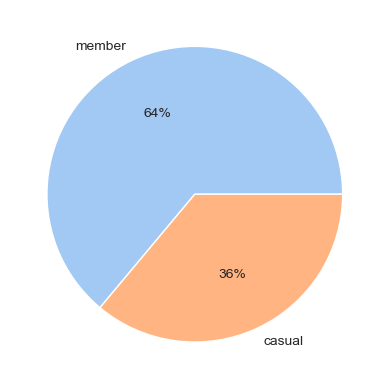

In [42]:
# plot the number of rides in each user group
plt.pie(user_group['count'], labels=user_group['member_casual'], colors=colors, autopct='%.0f%%') 
  
plt.show() 

## Rideable_type

In [44]:
# count how many rides in each rideable type and user group
ride_type = rides_df.groupby(['member_casual','rideable_type'])['ride_id'].count().reset_index()

In [45]:
ride_type['total'] = ride_type.groupby('member_casual')['ride_id'].transform(lambda x: x.sum())
ride_type['percent_of_total'] = ride_type['ride_id']/ride_type['total']*100
ride_type

,member_casual,rideable_type,ride_id,total,percent_of_total
0,casual,classic_bike,939581,2096237,44.822270
1,casual,electric_bike,1071583,2096237,51.119363
2,casual,electric_scooter,85073,2096237,4.058367
3,member,classic_bike,1809729,3713976,48.727536
4,member,electric_bike,1845129,3713976,49.680693
5,member,electric_scooter,59118,3713976,1.591771


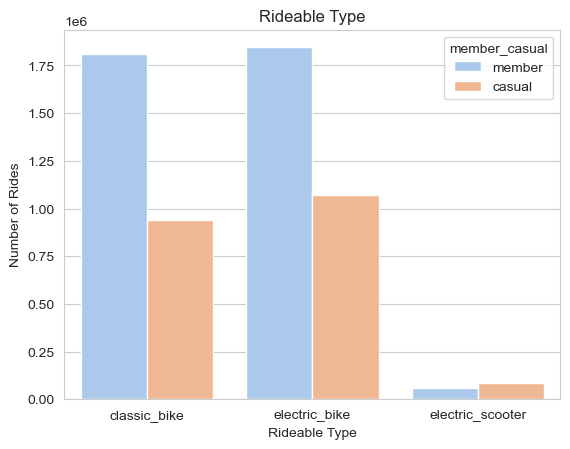

In [46]:
sns.barplot(ride_type, x="rideable_type", y="ride_id", hue="member_casual",hue_order=['member','casual'],palette=colors)

plt.xlabel("Rideable Type")
plt.ylabel("Number of Rides")
plt.title("Rideable Type")

plt.show() 

## Duration & Weekdays & Month

In [48]:
# duration analysis
# group by and see the average and std of each user group 
rides_df.groupby('member_casual')['duration_m'].agg(['std','mean'])

,std,mean
member_casual,,
casual,18.266483,17.835788
member,10.181283,11.591019


In [49]:
ri_duration = rides_df[['ride_id','duration_m','member_casual']]

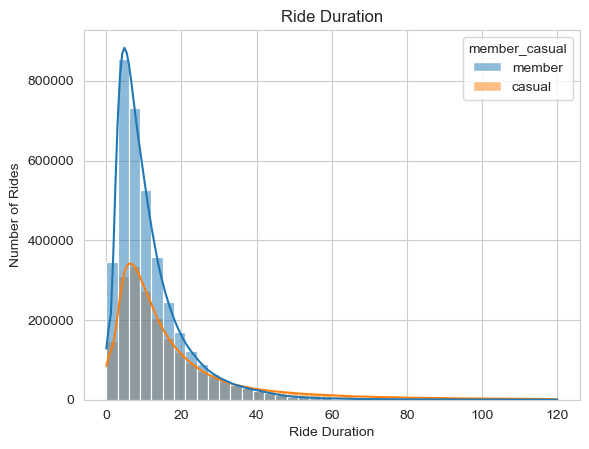

In [50]:
# plot histgram to see the duration distribution
sns.histplot(data=rides_df,x='duration_m',hue='member_casual',binwidth=3,kde=True)
plt.xlabel("Ride Duration")
plt.ylabel("Number of Rides")
plt.title("Ride Duration")

plt.show() 

In [51]:
# assign duration labels to get a more straightforward visualization
ri_duration['label_duration'] = np.where(ri_duration['duration_m']<=10,
                                         'less than 10 mins',
                                         np.where((ri_duration['duration_m'] <= 30) & (ri_duration['duration_m']>10),
                                                  'less than 30 mins',
                                                  np.where((ri_duration['duration_m'] <= 60) & (ri_duration['duration_m']>30),
                                                           'less than 60 mins',
                                                               np.where(ri_duration['duration_m'] >60,
                                                                    'more than 60 mins',
                                                                        'nan'
                                                               
                                                           )
                                                    
                                                      
                                                  )
                                             
                                         )
                                        )

/var/folders/lp/fhfn8drs4gz6mhfv1c20h4pr0000gn/T/ipykernel_69823/2569184294.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ri_duration['label_duration'] = np.where(ri_duration['duration_m']<=10,


In [52]:
ri_duration_plot = ri_duration.groupby(['member_casual','label_duration'])['ride_id'].count().reset_index()
ri_duration_plot

,member_casual,label_duration,ride_id
0,casual,less than 10 mins,891352
1,casual,less than 30 mins,875233
2,casual,less than 60 mins,238152
3,casual,more than 60 mins,91500
4,member,less than 10 mins,2128400
5,member,less than 30 mins,1380108
6,member,less than 60 mins,188021
7,member,more than 60 mins,17447


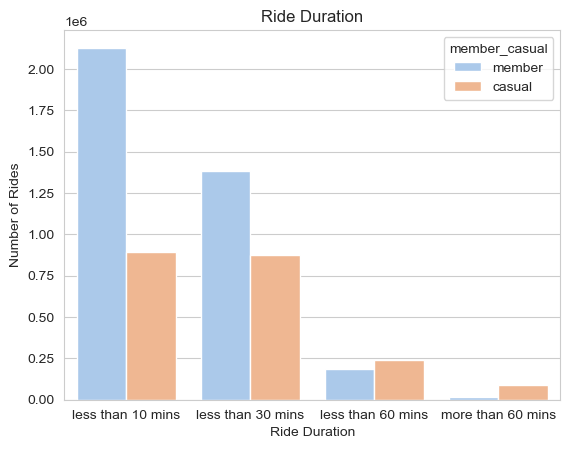

In [53]:
sns.barplot(data=ri_duration_plot,x='label_duration',y='ride_id',hue='member_casual',hue_order=['member','casual'],palette=colors)
plt.xlabel("Ride Duration")
plt.ylabel("Number of Rides")
plt.title("Ride Duration")

plt.show() 

In [54]:
# casual rider over 30 mins
c_over30 = (238152+91500)/2096237*100
m_over30 =	(188021+17447)/3713976*100
print(c_over30)
print(m_over30)

15.7258935893222
5.532292077277829


In [55]:
# month analysis
ride_month = rides_df.groupby(['member_casual','month'])['ride_id'].count().reset_index()
ride_month['shift_count'] = ride_month['ride_id'].shift(periods=1)
ride_month['percentage_of_difference'] = (ride_month['ride_id']-ride_month['shift_count'])/ride_month['shift_count']*100
ride_month

,member_casual,month,ride_id,shift_count,percentage_of_difference
0,casual,1,24123,NaN,NaN
1,casual,2,46455,24123.0,92.575550
2,casual,3,81286,46455.0,74.977936
3,casual,4,129562,81286.0,59.390301
4,casual,5,226484,129562.0,74.807428
5,casual,6,295580,226484.0,30.508115
6,casual,7,314573,295580.0,6.425672
7,casual,8,312978,314573.0,-0.507037
8,casual,9,342346,312978.0,9.383407
9,casual,10,174483,342346.0,-49.033142


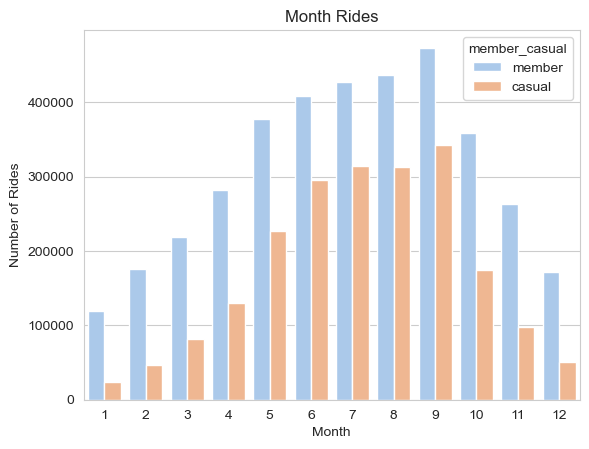

In [56]:
sns.barplot(data=ride_month,x='month',y='ride_id',hue='member_casual',hue_order=['member','casual'],palette=colors)
plt.xlabel("Month")
plt.ylabel("Number of Rides")
plt.title("Month Rides")
plt.show()

In [57]:
# weekday analysis
ride_weekday = rides_df.groupby(['member_casual','weekday'])['ride_id'].count().reset_index()

# convert weekday names to numbers using the mapto sort the table
weekday_map = {    'Monday': 0,
    'Tuesday': 1,
    'Wednesday': 2,
    'Thursday': 3,
    'Friday': 4,
    'Saturday': 5,
    'Sunday': 6
}

ride_weekday['weekday_num'] = ride_weekday['weekday'].map(weekday_map)
ride_weekday = ride_weekday.sort_values(by='weekday_num')
ride_weekday

,member_casual,weekday,ride_id,weekday_num
1,casual,Monday,250688,0
8,member,Monday,538955,0
5,casual,Tuesday,231310,1
12,member,Tuesday,569694,1
6,casual,Wednesday,267451,2
13,member,Wednesday,611692,2
4,casual,Thursday,264219,3
11,member,Thursday,582532,3
0,casual,Friday,301419,4
7,member,Friday,518692,4


In [58]:
# avg weekdays vs. weekends
c_weekend = (422147+359003)/2
c_weekday = (2096237-422147-359003)/5
m_weekend = (471895+420516)/2
m_weekday = (3713976-471895-420516)/5 

print((c_weekend-c_weekday)/c_weekday*100)
print((m_weekend-m_weekday)/m_weekday*100)

48.4977799947836
-20.929431007260156


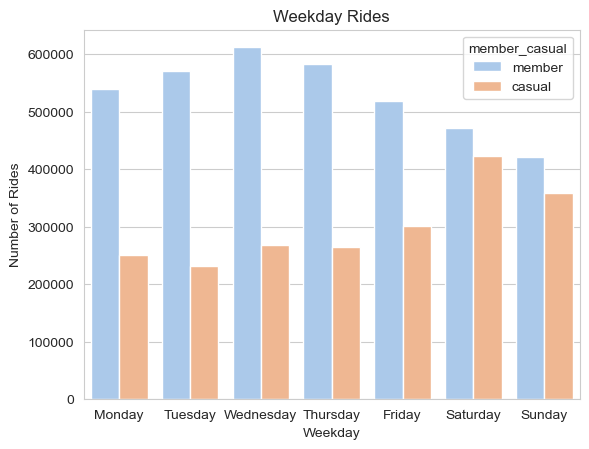

In [59]:
sns.barplot(data=ride_weekday,x='weekday',y='ride_id',hue='member_casual',hue_order=['member','casual'],palette=colors)
plt.xlabel("Weekday")
plt.ylabel("Number of Rides")
plt.title("Weekday Rides")
plt.show()

## Station analysis

In [61]:
member_df = rides_df[rides_df['member_casual']== 'member']
casual_df = rides_df[rides_df['member_casual']== 'casual']

In [62]:
print(sum(member_df['distance']==0)/3713976)
print(sum(casual_df['distance']==0)/2096237)

0.03571670899327298
0.08785075351689718


In [63]:
print(casual_df['start_station_name'].nunique())
print(member_df['start_station_name'].nunique())

1640
1649


In [64]:
casual_df.groupby(['start_station_name'])['ride_id'].count().sort_values(ascending=False).head(5)

start_station_name
Streeter Dr & Grand Ave               47738
DuSable Lake Shore Dr & Monroe St     31975
Michigan Ave & Oak St                 23889
DuSable Lake Shore Dr & North Blvd    22280
Millennium Park                       20976
Name: ride_id, dtype: int64

In [65]:
member_df.groupby(['start_station_name'])['ride_id'].count().sort_values(ascending=False).head(5)

start_station_name
Kingsbury St & Kinzie St        28670
Clinton St & Washington Blvd    28036
Clark St & Elm St               24518
Clinton St & Madison St         24422
Wells St & Concord Ln           20738
Name: ride_id, dtype: int64